In [1]:
# -*- coding: utf-8 -*-
"""
Integrated script for MALLET-based topic modeling with per-file Fisher’s Exact
filtering and stopword exclusion. UTF-8 friendly.
Outputs:
  - Topic keys
  - Per-document topic distributions
  - Excel workbook with:
      • Topic tokens
      • Token counts per document
      • Topic probabilities per document
  - Separate Excel workbook with top-document titles per topic

Graphical output (heatmap & boxplots) is disabled in this pipeline.
See plotting_helpers.py for on-demand plotting.
"""

import os
import csv
import time
from pathlib import Path
from collections import Counter

import pandas as pd
from scipy.stats import fisher_exact
import little_mallet_wrapper
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

# Path to your MALLET binary (adjust if needed)
path_to_mallet = os.path.expanduser("~/mallet-2.0.8/bin/mallet")

# These will be set by main() and picked up by plotting_helpers.py
OUTPUT_DIR = None
NUM_TOPICS = None

def tokenize_file(filepath):
    """Load a UTF-8 text file and split on whitespace (preserves accents)."""
    with open(filepath, "r", encoding="utf-8") as f:
        return f.read().split()

def list_txt_files(directory):
    """Return a sorted list of all .txt filenames in a directory."""
    return sorted(fn for fn in os.listdir(directory) if fn.endswith(".txt"))

def list_csv_files(directory):
    """
    Recursively find all .csv files under a directory, skipping
    any .ipynb_checkpoints folders.
    """
    csv_paths = []
    for root, dirs, files in os.walk(directory):
        if ".ipynb_checkpoints" in dirs:
            dirs.remove(".ipynb_checkpoints")
        for fn in files:
            if fn.lower().endswith(".csv"):
                csv_paths.append(os.path.join(root, fn))
    return csv_paths

def choose_directory(prompt):
    """
    Display a numbered list of immediate subdirectories (plus current dir)
    and return the full path selected by the user.
    """
    cwd = os.getcwd()
    base = Path(cwd).name
    subdirs = [
        d for d in os.listdir(cwd)
        if os.path.isdir(os.path.join(cwd, d)) and d != ".ipynb_checkpoints"
    ]
    options = [(os.path.join(cwd, d), f"{base}/{d}") for d in subdirs]
    options.append((cwd, base))

    print(prompt)
    for i, (_, label) in enumerate(options, start=1):
        print(f"{i}. {label}")

    while True:
        try:
            choice = int(input("Enter number: ").strip())
            if 1 <= choice <= len(options):
                return options[choice - 1][0]
        except ValueError:
            pass
        print("Invalid choice, please try again.")

def choose_files(filenames):
    """
    Let user pick one or more filenames by:
      - indices ("2" or "1,3")
      - index ranges ("1-4")
      - prefix matching ("report")
      - or the keyword "all" to select every file.
    Returns a sorted, unique list of chosen filenames.
    """
    print("Available files:")
    for i, fn in enumerate(filenames, start=1):
        print(f"{i}. {fn}")
    choice = input("Select files (indices, ranges, prefix, or 'all'): ").strip().lower()

    if choice == "all":
        return filenames.copy()

    selected = []
    for part in choice.split(","):
        part = part.strip()
        if part == "all":
            return filenames.copy()
        if "-" in part:
            a, b = map(int, part.split("-"))
            selected.extend(filenames[a - 1:b])
        elif part.isdigit():
            selected.append(filenames[int(part) - 1])
        else:
            selected.extend(fn for fn in filenames if fn.startswith(part))
    return sorted(set(selected))

def choose_csv_file(csv_paths):
    """
    Prompt the user to select one CSV from a list of paths.
    Returns the chosen filepath.
    """
    cwd = os.getcwd()
    base = Path(cwd).name
    print("Select your stopwords CSV:")
    for i, full in enumerate(csv_paths, start=1):
        rel = os.path.relpath(full, cwd)
        print(f"{i}. {base}/{rel}")

    while True:
        try:
            choice = int(input("Enter number: ").strip())
            if 1 <= choice <= len(csv_paths):
                return csv_paths[choice - 1]
        except ValueError:
            pass
        print("Invalid choice, please try again.")

def read_stopwords(filepath):
    """Load stopwords from a CSV, splitting on commas and trimming whitespace."""
    sw = []
    with open(filepath, "r", encoding="utf-8") as f:
        for row in csv.reader(f):
            for cell in row:
                sw.extend(cell.split(","))
    return [w.strip() for w in sw if w.strip()]

def get_fishers(word, freq_dict, rate_dict, alternative="greater"):
    """
    Perform Fisher’s Exact Test on one token:
        [[observed, total-observed],
         [expected, total-expected]]
    Returns the p-value.
    """
    observed = freq_dict.get(word, 0)
    total = sum(freq_dict.values())
    expected = round(rate_dict.get(word, 0) * total)
    table = [
        [observed, total - observed],
        [expected, total - expected]
    ]
    _, pval = fisher_exact(table, alternative=alternative)
    return pval

def calculate_rate_dictionary(rate_files, rate_dir):
    """
    Build a background rate dictionary from reference documents.
    Returns a mapping { token: relative_frequency }.
    """
    counter = Counter()
    total_tokens = 0
    for fn in rate_files:
        tokens = tokenize_file(os.path.join(rate_dir, fn))
        counter.update(tokens)
        total_tokens += len(tokens)
    return {tok: cnt / total_tokens for tok, cnt in counter.items()}

def prepare_training_data(files, directory, stopwords, rate_dict, alpha):
    """
    For each file:
      1. Tokenize and count every token.
      2. Exclude stopwords and tokens with Fisher p-value ≥ alpha.
      3. Collect filtered document text and raw token counts.
    Prints per-file progress with elapsed time.
    Returns:
      - docs: list of filtered document strings for MALLET input
      - distributions: list of Counter objects of raw token counts
    """
    docs = []
    distributions = []
    total = len(files)
    overall_start = time.time()

    for idx, fn in enumerate(files, start=1):
        file_start = time.time()
        print(f"[{idx}/{total}] ⏳ Processing '{fn}'... ", end="", flush=True)

        path = os.path.join(directory, fn)
        tokens = tokenize_file(path)
        freq = Counter(tokens)

        filtered = [
            w for w in tokens
            if w not in stopwords and get_fishers(w, freq, rate_dict) < alpha
        ]
        docs.append(" ".join(filtered))
        distributions.append(freq)

        elapsed = time.time() - file_start
        kept = len(filtered)
        before = len(tokens)
        pct = (kept / before * 100) if before else 0
        print(f"done in {elapsed:.1f}s – kept {kept}/{before} tokens ({pct:.1f}%).")

    total_elapsed = time.time() - overall_start
    print(f"[Done] Prepared {total} documents in {total_elapsed:.1f}s.\n")
    return docs, distributions

def train_topic_model(training_docs, num_topics, output_dir):
    """
    Train a MALLET model via little_mallet_wrapper
    Returns:
      - topics: list of token lists (topic keys)
      - doc_topics: list of probability lists (per-document topic distributions)
    """
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    little_mallet_wrapper.quick_train_topic_model(
        path_to_mallet,
        output_dir,
        num_topics,
        training_docs
    )

    key_file = f"{output_dir}/mallet.topic_keys.{num_topics}"
    topics = little_mallet_wrapper.load_topic_keys(key_file)

    dist_file = f"{output_dir}/mallet.topic_distributions.{num_topics}"
    doc_topics = little_mallet_wrapper.load_topic_distributions(dist_file)

    return topics, doc_topics

def save_results_to_excel(excel_path, topics, token_distributions, doc_topics, files):
    """
    Create an Excel workbook with:
      1) 'Topics' sheet: one row per topic (Topic#, top tokens...)
      2) One sheet per document: raw token counts (removing '_stemmed' suffix)
      3) 'DocTopicDist' sheet: topic probabilities per document
    """
    wb = Workbook()
    ws0 = wb.active
    ws0.title = "Topics"
    for idx, topic in enumerate(topics):
        ws0.append([f"Topic {idx}"] + topic)

    for fn, dist in zip(files, token_distributions):
        # Remove '_stemmed' suffix from sheet names
        sheet_name = Path(fn).stem.replace("_stemmed", "")
        sheet = wb.create_sheet(title=sheet_name)
        df = pd.DataFrame.from_dict(dist, orient="index", columns=["count"])
        for row in dataframe_to_rows(df, index=True, header=True):
            sheet.append(row)

    ws3 = wb.create_sheet(title="DocTopicDist")
    header = ["Document"] + [f"Topic{t}" for t in range(len(topics))]
    ws3.append(header)
    for fn, probs in zip(files, doc_topics):
        doc_name = Path(fn).stem.replace("_stemmed", "")
        ws3.append([doc_name] + [round(p, 4) for p in probs])

    wb.save(excel_path)

def save_top_titles_excel(xlsx_path, topics, training_docs, doc_topics, doc_titles, n_docs):
    """
    Save the top n_docs document titles per topic into an Excel file,
    one sheet per topic named 'Topic{#}', and remove the default blank sheet.
    """
    wb = Workbook()
    # Remove the default blank sheet
    default_sheet = wb.active
    wb.remove(default_sheet)

    for t_idx in range(len(topics)):
        ws = wb.create_sheet(title=f"Topic{t_idx}")
        ws.append(["Probability", "Document Title"])
        for prob, doc in little_mallet_wrapper.get_top_docs(
            training_docs, doc_topics, t_idx, n=n_docs
        ):
            title = doc_titles.get(doc, Path(doc).stem)
            ws.append([round(prob, 4), title])

    wb.save(xlsx_path)

def input_float(prompt, min_val=None, max_val=None):
    """Prompt until the user enters a valid float (and optionally within range)."""
    while True:
        resp = input(prompt).strip()
        try:
            val = float(resp)
            if min_val is not None and val < min_val:
                print(f"Value must be at least {min_val}.")
                continue
            if max_val is not None and val > max_val:
                print(f"Value must be at most {max_val}.")
                continue
            return val
        except ValueError:
            print("Invalid input, please enter a valid number.")

def input_int(prompt, min_val=None, max_val=None):
    """Prompt until the user enters a valid integer (and optionally within range)."""
    while True:
        resp = input(prompt).strip()
        try:
            val = int(resp)
            if min_val is not None and val < min_val:
                print(f"Value must be at least {min_val}.")
                continue
            if max_val is not None and val > max_val:
                print(f"Value must be at most {max_val}.")
                continue
            return val
        except ValueError:
            print("Invalid input, please enter a valid integer.")

def main():
    global OUTPUT_DIR, NUM_TOPICS

    # 1) Choose and load stopwords CSV
    stop_csv = choose_csv_file(list_csv_files(os.getcwd()))
    stopwords = read_stopwords(stop_csv)

    # 2) Build background rate dictionary
    rate_dir = choose_directory("Select reference text directory:")
    rate_files = choose_files(list_txt_files(rate_dir))
    rate_dict = calculate_rate_dictionary(rate_files, rate_dir)

    # 3) Select target files
    target_dir = choose_directory("Select target text directory:")
    target_files = choose_files(list_txt_files(target_dir))

    # 4) Fisher’s Exact threshold
    alpha = input_float(
        "Enter Fisher’s Exact alpha threshold (e.g. 0.05): ",
        min_val=0.0, max_val=1.0
    )

    # 5) Prepare filtered training data
    training_docs, token_distributions = prepare_training_data(
        target_files, target_dir, stopwords, rate_dict, alpha
    )

    # 6) Number of topics
    num_topics = input_int("Enter number of topics to generate: ", min_val=1)

    # 7) How many top documents per topic
    n_top_docs = input_int("Enter number of top documents per topic: ", min_val=1)

    # 8) Output folder
    while True:
        out_sub = input("Enter name for output folder: ").strip()
        if out_sub:
            break
        print("Output folder name cannot be empty.")
    OUTPUT_DIR = os.path.join(os.getcwd(), out_sub)
    NUM_TOPICS = num_topics
    Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

    # 9) Train model and load topic keys + doc-topic distributions
    topics, doc_topics = train_topic_model(
        training_docs, NUM_TOPICS, OUTPUT_DIR
    )

    # Save the list of processed files for plotting_helpers
    fn_list_path = os.path.join(OUTPUT_DIR, "input_filenames.txt")
    with open(fn_list_path, "w", encoding="utf-8") as f:
        for fn in target_files:
            f.write(fn + "\n")

    # 10) Save combined results to Excel
    excel_results = os.path.join(OUTPUT_DIR, "topic_model_results.xlsx")
    save_results_to_excel(
        excel_results, topics, token_distributions, doc_topics, target_files
    )

    # 11) Save top titles per topic to separate workbook
    doc_titles = {doc: Path(fn).stem for doc, fn in zip(training_docs, target_files)}
    top_titles_path = os.path.join(OUTPUT_DIR, "top_titles.xlsx")
    save_top_titles_excel(
        top_titles_path, topics, training_docs, doc_topics, doc_titles, n_top_docs
    )

    print("✅ Topic modeling pipeline completed successfully!")
    print("ℹ️  No plots were generated. To create heatmaps or boxplots,")
    print("    import and run plotting_helpers.generate_heatmap() or generate_boxplots().")

if __name__ == "__main__":
    main()

Select your stopwords CSV:
1. lemmatized/stop_words.csv


Enter number:  1


Select reference text directory:
1. lemmatized/8Topics
2. lemmatized


Enter number:  2


Available files:
1. Bodin_stemmed.txt
2. L'Hospital_stemmed.txt


Select files (indices, ranges, prefix, or 'all'):  all


Select target text directory:
1. lemmatized/8Topics
2. lemmatized


Enter number:  2


Available files:
1. Bodin_stemmed.txt
2. L'Hospital_stemmed.txt


Select files (indices, ranges, prefix, or 'all'):  all
Enter Fisher’s Exact alpha threshold (e.g. 0.05):  0.05


[1/2] ⏳ Processing 'Bodin_stemmed.txt'... done in 132.6s – kept 42485/753572 tokens (5.6%).
[2/2] ⏳ Processing 'L'Hospital_stemmed.txt'... done in 15.1s – kept 53448/263789 tokens (20.3%).
[Done] Prepared 2 documents in 147.7s.



Enter number of topics to generate:  8
Enter number of top documents per topic:  5
Enter name for output folder:  8Topics2


Importing data...
Complete
Training topic model...


Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 52938
total tokens: 94105
<10> LL/token: -6.59091
<20> LL/token: -6.40823
<30> LL/token: -6.32304
<40> LL/token: -6.2794

0	0.625	republ chos natur voir eau fin part magistrat puissanc grec naturel outr def fort esclav celà yeux feul soleil rout 
1	0.625	avaric doibvent bel maulv compaign meschan mani jur quitt sion sien gaign chemin apport accoustum enfin bénéfic ambassadeur ministr observ 
2	0.625	chos fort corp fer puissanc sorci republ jug part form iour natur ame veut veu sag fin ble monarch verit 
3	0.625	part fort corp magistrat deu chos doit matier fois veu feu air animal form pierr sorci mieux senat naturel haut 
4	0.625	roy bon mémoir justic bien gard party judg estat charg prendr mill laiss réform dev ordre harangu argent temp caus 
5	0.625	homm estat main justic réform injustic sort temp traict affair duc vertu honneur public roy mal charl baill droit bien 
6	0.625	author évesqu menac nanc adjoust r

Complete
✅ Topic modeling pipeline completed successfully!
ℹ️  No plots were generated. To create heatmaps or boxplots,
    import and run plotting_helpers.generate_heatmap() or generate_boxplots().


Enter heatmap width in pixels (e.g. 1600):  4500


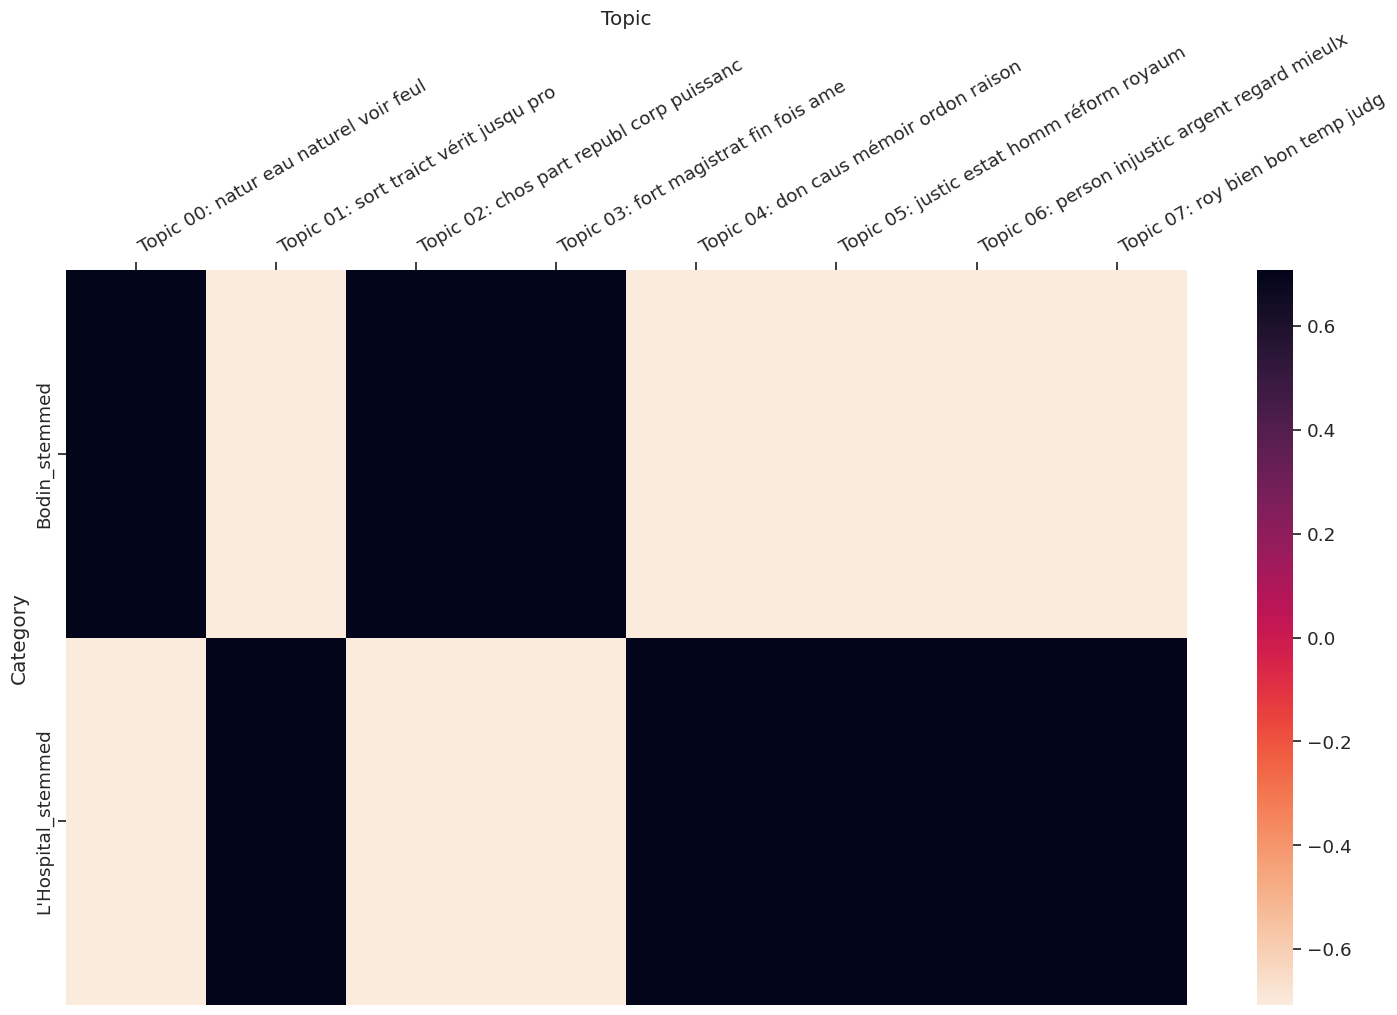

Heatmap saved: /home/lucas-jerusalimiec/Documents/OCR Text/Text/Corpora/Concatenated/lemmatized/8Topics2/categories_by_topics.pdf, /home/lucas-jerusalimiec/Documents/OCR Text/Text/Corpora/Concatenated/lemmatized/8Topics2/heatmap.png


In [ ]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import little_mallet_wrapper

# Defaults
DEFAULT_DPI = 300
DEFAULT_DIM_INCHES = (13, 9)  # (width in inches, height in inches)

def _load_model_results():
    """
    Load topic keys, distributions, and filenames from the last pipeline run.
    """
    if not OUTPUT_DIR or not NUM_TOPICS:
        raise RuntimeError(
            "OUTPUT_DIR and NUM_TOPICS must be set at module level. "
            "Define them before calling plotting functions."
        )

    key_file = os.path.join(OUTPUT_DIR, f"mallet.topic_keys.{NUM_TOPICS}")
    dist_file = os.path.join(OUTPUT_DIR, f"mallet.topic_distributions.{NUM_TOPICS}")
    topics = little_mallet_wrapper.load_topic_keys(key_file)
    doc_topics = little_mallet_wrapper.load_topic_distributions(dist_file)

    fn_list = os.path.join(OUTPUT_DIR, "input_filenames.txt")
    with open(fn_list, "r", encoding="utf-8") as f:
        files = [line.strip() for line in f]

    return files, topics, doc_topics

def generate_heatmap():
    """
    Prompt for a desired chart width in pixels, then generate and save a
    topic-by-document heatmap. The chart height and DPI adjust automatically
    to preserve proportions and resolution.  Exports only PDF + PNG.
    """
    # 1) Prompt user for chart width in pixels
    try:
        width_px = int(input("Enter heatmap width in pixels (e.g. 1600): ").strip())
    except ValueError:
        width_px = int(DEFAULT_DIM_INCHES[0] * DEFAULT_DPI)
        print(f"Invalid input, defaulting to {width_px} px width ({DEFAULT_DPI} DPI).")

    # 2) Compute figure size in inches to maintain aspect ratio
    dpi_value = DEFAULT_DPI
    aspect = DEFAULT_DIM_INCHES[1] / DEFAULT_DIM_INCHES[0]
    height_px = int(width_px * aspect)
    figsize = (width_px / dpi_value, height_px / dpi_value)

    # 3) Load model results
    files, topics, doc_topics = _load_model_results()
    labels = [Path(fn).stem for fn in files]

    # 4) Close any prior figure
    plt.close('all')

    # 5) Generate heatmap; wrapper will save PDF internally
    pdf_out = os.path.join(OUTPUT_DIR, "categories_by_topics.pdf")
    fig = little_mallet_wrapper.plot_categories_by_topics_heatmap(
        labels,
        doc_topics,
        topics,
        pdf_out,
        target_labels=labels,
        dim=figsize
    )

    # 6) Ensure we have a Matplotlib Figure
    if fig is None:
        fig = plt.gcf()

    # 7) Draw and save as PNG
    fig.canvas.draw()
    png_out = os.path.join(OUTPUT_DIR, "heatmap.png")
    fig.savefig(png_out, dpi=dpi_value)
    plt.close(fig)

    print(f"Heatmap saved: {pdf_out}, {png_out}")

def generate_boxplot_grid():
    """
    Prompt for a desired chart width in pixels, then draw a grid of boxplots
    (one subplot per topic) and save as a single PDF + PNG. Height and DPI
    adjust automatically to preserve proportions and resolution. Exports only PDF + PNG.
    """
    # 1) Prompt user for chart width in pixels
    try:
        width_px = int(input("Enter boxplot-grid width in pixels (e.g. 1600): ").strip())
    except ValueError:
        width_px = int(DEFAULT_DIM_INCHES[0] * DEFAULT_DPI)
        print(f"Invalid input, defaulting to {width_px} px width ({DEFAULT_DPI} DPI).")

    # 2) Compute figure size in inches
    dpi_value = DEFAULT_DPI
    aspect = DEFAULT_DIM_INCHES[1] / DEFAULT_DIM_INCHES[0]
    height_px = int(width_px * aspect)
    figsize = (width_px / dpi_value, height_px / dpi_value)

    # 3) Load model results
    files, topics, doc_topics = _load_model_results()
    labels = [Path(fn).stem for fn in files]
    n_topics = len(topics)

    # 4) Layout: 2 columns, as many rows as needed
    cols = 2
    rows = (n_topics + cols - 1) // cols

    # 5) Create figure + axes grid
    plt.close('all')
    fig, axes = plt.subplots(rows, cols,
                             figsize=figsize,
                             dpi=dpi_value,
                             sharex=True)
    axes = axes.flatten()

    # 6) Populate each subplot with horizontal boxplot for one topic
    for t_idx in range(n_topics):
        ax = axes[t_idx]
        data = [doc_topics[i][t_idx] for i in range(len(doc_topics))]
        ax.boxplot(data, vert=False)
        ax.set_title(f"Topic {t_idx}")
        ax.set_yticks([])

    # 7) Turn off any unused axes
    for ax in axes[n_topics:]:
        ax.axis("off")

    fig.tight_layout()

    # 8) Save outputs
    pdf_path = os.path.join(OUTPUT_DIR, "all_topic_boxplots.pdf")
    png_path = os.path.join(OUTPUT_DIR, "all_topic_boxplots.png")
    fig.savefig(pdf_path)
    fig.savefig(png_path, dpi=dpi_value)
    plt.close(fig)

    print(f"Boxplot grid saved: {pdf_path}, {png_path}")

def generate_all_plots():
    """
    1) Generate heatmap (width prompt)
    2) Generate a grid of boxplots (width prompt)
    """
    generate_heatmap()
    generate_boxplot_grid()

# Example usage:
# >>> OUTPUT_DIR = "/path/to/output"
# >>> NUM_TOPICS = 10
# >>> generate_all_plots()
if __name__ == "__main__":
    generate_all_plots()